In [283]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import string
import re
import requests
import os
import textwrap

# Load data

In [284]:
if not os.path.exists('moby_dick.txt'):
  print("Downloading moby dick...")
  r = requests.get('https://lazyprogrammer.me/course_files/moby_dick.txt')
  with open('moby_dick.txt', 'w') as f:
    f.write(r.content.decode())


# for replacing non-alpha characters
regex = re.compile('[^a-zA-Z]')

moby_dick_lines = []
for line in open('moby_dick.txt'):
  line = line.rstrip()
  # there are blank lines in the file
  if line:
    moby_dick_lines.append(regex.sub(' ', line)) # replace all non-alpha characters with space

print('Moby dick number of lines:', len(moby_dick_lines))
print('First 3 lines:', moby_dick_lines[:3])

moby_dick_words = []
for line in moby_dick_lines:
  moby_dick_words += line.lower().split()

print('Moby dick number of words:', len(moby_dick_words))
print('First 30 words:', moby_dick_words[:30])


sherlock_holmes = '''I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.
'''

sherlock_holmes_clean = regex.sub(' ', sherlock_holmes.lower())
print('Sherlock Holmes orginal text cleaned and to be encoded:')
print(sherlock_holmes_clean)

Moby dick number of lines: 18391
First 3 lines: [' CHAPTER    Loomings ', 'Call me Ishmael  Some years ago never mind how long precisely having', 'little or no money in my purse  and nothing particular to interest me']
Moby dick number of words: 214702
First 30 words: ['chapter', 'loomings', 'call', 'me', 'ishmael', 'some', 'years', 'ago', 'never', 'mind', 'how', 'long', 'precisely', 'having', 'little', 'or', 'no', 'money', 'in', 'my', 'purse', 'and', 'nothing', 'particular', 'to', 'interest', 'me', 'on', 'shore', 'i']
Sherlock Holmes orginal text cleaned and to be encoded:
i then lounged down the street and found  as i expected  that there was a mews in a lane which runs down by one wall of the garden  i lent the ostlers a hand in rubbing down their horses  and received in exchange twopence  a glass of half and half  two fills of shag tobacco  and as much information as i could desire about miss adler  to say nothing of half a dozen other people in the neighbourhood in whom i was not 

# Utils

In [303]:
class IDiscreteProbabilityModel():
  def fit(self, x):
    pass

  def get_log_joint_prob(self, x):
    pass


class SimpleMarkovModel(IDiscreteProbabilityModel):
  def __init__(self, n_states):
    self.n_states = n_states
    self.log_pi = None
    self.log_A = None
  
  def fit(self, x):
    n = len(x)
    pi_count = np.ones(self.n_states) # t_0 probability distirubtion of initial state of s
    A_count = np.ones((self.n_states, self.n_states)) # A[i, j] - prob of transition from state s[i] to state s[j]
    for idx, x_cur in enumerate(x):
      pi_count[x_cur[0]] += 1.0
      for t in range(1, len(x_cur)):
        A_count[x_cur[t-1], x_cur[t]] += 1.0

    pi = pi_count / pi_count.sum()
    A = A_count / A_count.sum(axis=1, keepdims=True)

    self.log_pi = np.log(pi)
    self.log_A = np.log(A)

  def get_log_joint_prob(self, x):
    log_ll = self.log_pi[x[0]]
    for t in range(1, len(x)):
      log_ll += self.log_A[x[t-1], x[t]]
    return log_ll


class LanguageModel():
  # 1st order Markov Model

  def __init__(self):
    self.model = SimpleMarkovModel(n_states=len(string.ascii_lowercase))
    self.char2idx = {c: idx for idx, c in enumerate(string.ascii_lowercase)}
    self.idx2char = [c for c in string.ascii_lowercase]

  def fit(self, x):
    x_as_idx = []
    for word in x:
      x_as_idx.append([self.char2idx[c] for c in word])
    self.model.fit(x_as_idx)
  
  def word_log_prob(self, word):
    word_as_idx = [self.char2idx[c] for c in word]
    return self.model.get_log_joint_prob(word_as_idx)
  
  def sentence_prob(self, sentence):
    log_p = 0
    if type(sentence) == str:
      words = sentence.split()
    else:
      words = sentence

    for word in words:
      log_p += self.word_log_prob(word)
    return log_p


# test od the language model with results from the course
lm_test = LanguageModel()
lm_test.fit(moby_dick_words)
assert np.abs(lm_test.sentence_prob(sherlock_holmes_clean) - (-933.03)) < 0.01

In [304]:
lm_test.sentence_prob('q')

-5.702051549295922

In [305]:
class AlphabetSubstitutionCipher:
  def __init__(self, coding_dict=None):
    if coding_dict is not None:
      assert isinstance(coding_dict, dict)
      self.encode_dict = coding_dict
    else:
      self.encode_dict = self._generate_random_coder()
    self.decode_dict = self._set_decode_dict(self.encode_dict)
  

  def _set_decode_dict(self, coding_dict):
    decode_dict = {}
    for org, coded in coding_dict.items():
      decode_dict[coded] = org
    return decode_dict


  def _generate_random_coder(self):
    coding_dict = {}
    org_letters = list(string.ascii_lowercase)
    swapped_letters = list(string.ascii_lowercase)
    np.random.shuffle(swapped_letters)
    for org, coded in zip(org_letters, swapped_letters):
      coding_dict[org] = coded
    return coding_dict


  def encript(self, txt):
    assert isinstance(txt, str)

    encripted = []
    for c in txt:
      if c in self.encode_dict: # could just be a space
        encripted.append(self.encode_dict[c])
      else:
        encripted.append(c)
    return ''.join(encripted)


  def decript(self, txt):
    assert isinstance(txt, str)

    decripted = []
    for c in txt:
      if c in self.decode_dict: # could just be a space
        decripted.append(self.decode_dict[c])
      else:
        decripted.append(c)
    return ''.join(decripted)


  def mutate(self):
    l1, l2 = np.random.choice(list(self.encode_dict.keys()), size=2, replace=False)

    temp = self.encode_dict[l1]
    self.encode_dict[l1] = self.encode_dict[l2]
    self.encode_dict[l2] = temp

    self.decode_dict = self._set_decode_dict(self.encode_dict)

  def copy(self):
    return AlphabetSubstitutionCipher(self.encode_dict)
  
  @staticmethod
  def test(coding_dict=None):
    print('test:\n')
    cipher = AlphabetSubstitutionCipher(coding_dict)
    print(cipher.encode_dict)
    print(cipher.decode_dict)
    #print('\n')
    print(cipher.encript('a b c'))
    print(cipher.decript('a b r'))
    print('\n')

    cipher.mutate()
    print(cipher.encode_dict)
    print(cipher.decode_dict)
    #print('\n')
    print(cipher.encript('ab  c'))
    print(cipher.decript('a  br'))
    print('\n')

AlphabetSubstitutionCipher.test({'a':'a', 'b':'b', 'c':'r', 'r':'c'})

test:

{'a': 'a', 'b': 'b', 'c': 'r', 'r': 'c'}
{'a': 'a', 'b': 'b', 'r': 'c', 'c': 'r'}
a b r
a b c


{'a': 'r', 'b': 'b', 'c': 'a', 'r': 'c'}
{'r': 'a', 'b': 'b', 'a': 'c', 'c': 'r'}
rb  a
c  ba




In [306]:
class GeneticEvolution():
  def __init__(self, baseline_encripted_message, language_model, init_dna_pool_size=20, max_best_fitted_dnas=5):
    self.baseline_encripted_message = baseline_encripted_message
    self.model = language_model
    self.dna_pool_size = max_best_fitted_dnas
    random_dnas = []
    for p in range(init_dna_pool_size):
      dna_chipher = AlphabetSubstitutionCipher() # generate random dnas (substitution alfabeths)
      decripted_message_with_dna = dna_chipher.decript(self.baseline_encripted_message)
      dna_fit = self.model.sentence_prob(decripted_message_with_dna)
      random_dnas.append((dna_chipher, dna_fit))
    self.dna_pool = sorted(random_dnas, key=lambda x: x[1], reverse=True)
    self.finess_history = []
    fitness_avg = np.mean([dna[1] for dna in self.dna_pool])
    self.finess_history.append((fitness_avg, self.dna_pool[0][1]))

  def evolve_one_epoch(self, n_offsprings):
    new_dna_pool = []
    for dna in self.dna_pool:
      new_dna_pool.append(dna)
      for _ in range(n_offsprings):
        offspring = dna[0].copy()
        offspring.mutate()
        offspring_decripted_message = offspring.decript(self.baseline_encripted_message)
        offspring_dna_fit = self.model.sentence_prob(offspring_decripted_message)
        new_dna_pool.append((offspring, offspring_dna_fit))

    fitness_avg = np.mean([dna[1] for dna in new_dna_pool])
    new_dna_pool = sorted(new_dna_pool, key=lambda x: x[1], reverse=True)
    print([pair[1] for pair in new_dna_pool])
    self.dna_pool = new_dna_pool[:self.dna_pool_size]
    self.finess_history.append((fitness_avg, self.dna_pool[0][1]))

  def evolve(self, n_epochs, n_offsprings):
    for _ in range(n_epochs):
      self.evolve_one_epoch(n_offsprings)
    return self.print_history()
  
  def print_history(self):
    return pd.DataFrame(self.finess_history, columns=['fitness_avg', 'best_fit'])

# Find cipher decriptior with genetic algorithm

In [319]:
true_cipher = AlphabetSubstitutionCipher()
encripted_sherlock_holmes = true_cipher.encript(sherlock_holmes_clean)

print('Decripted Sherlock Holmes:')
print(sherlock_holmes_clean[:130])
print('Encripted Sherlock Holmes:')
print(encripted_sherlock_holmes[:130])

Decripted Sherlock Holmes:
i then lounged down the street and found  as i expected  that there was a mews in a lane which runs down by one wall of the garden
Encripted Sherlock Holmes:
u oife ytleqfc ctme oif wobffo dec ktlec  dw u fzsfaofc  oido oifbf mdw d vfmw ue d ydef miuai blew ctme pj tef mdyy tk oif qdbcfe


In [320]:
language_model = LanguageModel()
language_model.fit(moby_dick_words)

language_model.sentence_prob(true_cipher.decript(encripted_sherlock_holmes))

-933.0339420615785

[-1750.6706780376553, -1811.5541984382253, -1823.8676531857166, -1833.2414423523378, -1834.0604391037887, -1854.5756193257498, -1857.1180412011395, -1859.0600942949343, -1913.025399205437, -1929.704532636457, -1932.3448506032128, -1936.8970313335137, -1940.4580151394011, -1940.4580151394011, -1945.6412954274983, -1949.076424420937, -1950.9428491186088, -1968.199667026935, -1969.084763648594, -1972.1799814733627, -1975.1220426898763, -1990.0700425442901, -1994.2392397145782, -1999.393257368709, -2025.1176108208138, -2027.4461383953565, -2043.7440793039616, -2049.0115049098304, -2056.367386405446, -2058.4548271436665, -2064.2246541459463, -2068.202915609083, -2070.9363390770345, -2078.027306107423, -2086.400673508654, -2089.9567674281566, -2093.43944677809, -2094.2835830730346, -2094.951585803684, -2098.9239119761155, -2108.910261123724, -2109.8909444900896, -2110.5227071225477, -2115.2582184857356, -2115.8349246673156, -2117.0822903306334, -2120.190759040794, -2126.3172988728925, -2129.

,fitness_avg,best_fit
0,-2088.366962,-1857.118041
1,-2091.360583,-1750.670678
2,-1830.133787,-1750.670678
3,-1942.751069,-1750.670678
4,-2152.475020,-1750.670678
...,...,...
96,-1873.712036,-1659.427816
97,-1952.491196,-1659.427816
98,-1998.055856,-1659.427816
99,-2049.962879,-1659.427816


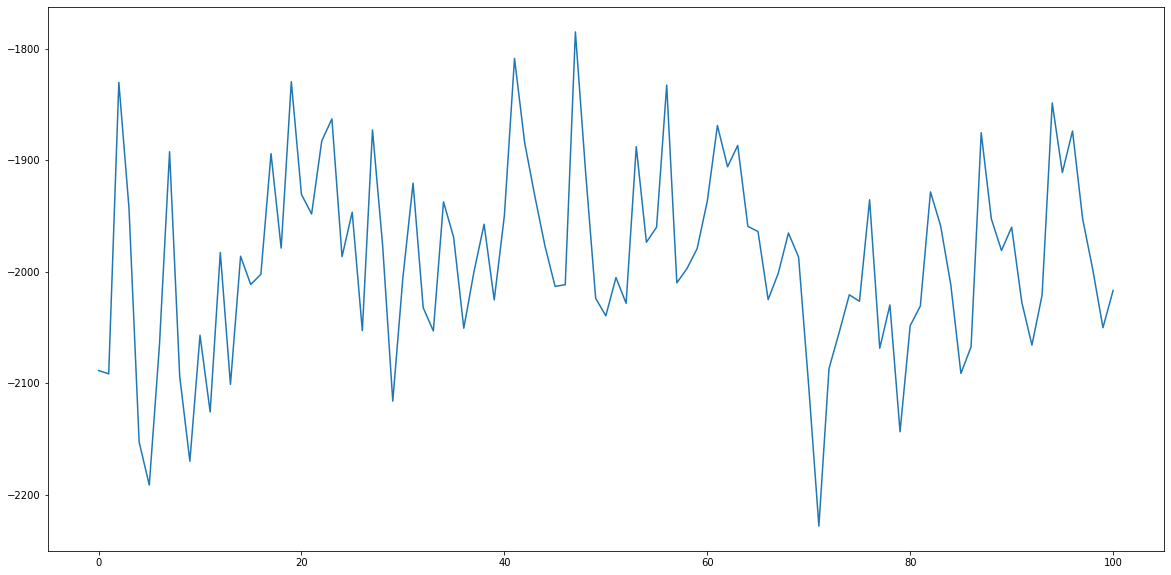

In [321]:
dna_evolution_simulator = GeneticEvolution(encripted_sherlock_holmes, language_model)
evolution_history = dna_evolution_simulator.evolve(n_epochs=100, n_offsprings=3)

plt.figure(figsize=(20,10))
plt.plot(evolution_history['fitness_avg'])
evolution_history

In [322]:
best_decoder = dna_evolution_simulator.dna_pool[0][0]
best_decoder.decript(encripted_sherlock_holmes)

'a yfrn bilnwru uitn yfr eymrry gnu xilnu  ge a rzorkyru  yfgy yfrmr tge g drte an g bgnr tfakf mlne uitn jh inr tgbb ix yfr wgmurn  a brny yfr ieybrme g fgnu an mljjanw uitn yfram fimere  gnu mrkracru an rzkfgnwr ytiornkr  g wbgee ix fgbx gnu fgbx  yti xabbe ix efgw yijgkki  gnu ge dlkf anximdgyain ge a kilbu ureamr gjily daee gubrm  yi egh niyfanw ix fgbx g uiprn iyfrm oriobr an yfr nrawfjilmfiiu an tfid a tge niy an yfr brgey anyrmreyru  jly tfier jaiwmgofare a tge kidorbbru yi baeyrn yi  '